In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# External datasets

In [2]:
countries = pd.read_csv("preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3
0,Afghanistan,Asia,AF,AF,AFG
1,Albania,Europe,AL,AL,ALB
2,Algeria,Africa,AG,DZ,DZA
3,American Samoa,Oceania,AQ,AS,ASM
4,Andorra,Europe,AN,AD,AND


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

In [3]:
hdi = pd.read_csv("human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [4]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

In [5]:
epi = pd.read_csv("epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [6]:
epi = epi[["iso", "country", "GDPpc", "PopDensity", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,PopDensity,EPI2018Score
iso,,,,
AFG,Afghanistan,1739.583177,53.083405,37.74
ALB,Albania,11359.099160,104.967190,65.46
DZA,Algeria,13921.176080,17.048895,57.18
AGO,Angola,5984.632947,23.111786,37.44
ATG,Antigua and Barbuda,21013.017630,229.461364,59.18


In [7]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")["FIPS"])
external_data.head(5)

,hdi_2017,country,GDPpc,PopDensity,EPI2018Score,FIPS
ISO3,,,,,,
AFG,0.498,Afghanistan,1739.583177,53.083405,37.74,AF
AGO,0.581,Angola,5984.632947,23.111786,37.44,AO
ALB,0.785,Albania,11359.099160,104.967190,65.46,AL
AND,0.858,NaN,NaN,NaN,NaN,AN
ARE,0.863,United Arab Emirates,67133.014840,110.880526,58.90,AE


# Mentions ratios by geolocalized domain states

In [8]:
ratios_domains = pd.read_csv("mentions_counts_by_state_and_day_DOMAIN.csv")
ratios_domains = ratios_domains.assign(DATE=pd.to_datetime(ratios_domains[["YEAR", "MONTH", "DAY"]]))
ratios_domains.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
ratios_domains.dropna(inplace=True)
ratios_domains.sample(10)

,STATE,DOMAIN_COUNTRY,GLOBAL_COUNT,ENV_COUNT,DATE
14052,SZ,Switzerland,1034,330.0,2016-01-14
105306,SF,South Africa,7167,1543.0,2016-02-22
30937,LY,Libya,120,13.0,2017-09-13
45584,FI,Finland,49,5.0,2016-06-11
79440,SZ,Switzerland,608,32.0,2016-02-14
32835,TD,Trinidad and Tobago,200,19.0,2017-06-10
87477,JM,Jamaica,777,197.0,2016-08-31
47283,IN,India,30111,5046.0,2017-10-26
129179,SU,Sudan,285,49.0,2017-07-13
26098,NP,Nepal,959,260.0,2015-09-29


In [9]:
means = ratios_domains.groupby("STATE").mean()
means = means.assign(MEAN=means.ENV_COUNT/means.GLOBAL_COUNT)[["MEAN"]]
medians = ratios_domains.groupby("STATE").median()
medians = medians.assign(MEDIAN=medians.ENV_COUNT/medians.GLOBAL_COUNT)[["MEDIAN"]]

In [10]:
means.head(5)

,MEAN
STATE,
AA,1.000000
AC,0.774038
AE,0.269992
AF,0.171447
AG,0.257637


In [11]:
medians.head(5)

,MEDIAN
STATE,
AA,1.000000
AC,1.000000
AE,0.258845
AF,0.130755
AG,0.177778


In [12]:
ratios = means.join(medians)
ratios.sample(10)

,MEAN,MEDIAN
STATE,,
ES,0.977778,1.000000
VE,0.253418,0.221374
MX,0.290672,0.245763
TW,0.215156,0.207834
NH,0.418352,0.350000
CS,0.323202,0.275862
RS,0.557274,0.561537
YM,0.353061,0.300000
VM,0.347832,0.301862


# Join to external datasets

In [13]:
joined = ratios.join(external_data.set_index("FIPS", drop=True), how="left")
joined.head(5)

,MEAN,MEDIAN,hdi_2017,country,GDPpc,PopDensity,EPI2018Score
AA,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
AC,0.774038,1.000000,0.780,Antigua and Barbuda,21013.017630,229.461364,59.18
AE,0.269992,0.258845,0.863,United Arab Emirates,67133.014840,110.880526,58.90
AF,0.171447,0.130755,0.498,Afghanistan,1739.583177,53.083405,37.74
AG,0.257637,0.177778,0.754,Algeria,13921.176080,17.048895,57.18


In [14]:
joined.describe()

,MEAN,MEDIAN,hdi_2017,GDPpc,PopDensity,EPI2018Score
count,222.000000,222.000000,189.000000,180.000000,180.000000,180.000000
mean,0.380977,0.342284,0.714651,18132.726882,195.054741,56.875556
std,0.249969,0.266660,0.152491,19193.729284,625.282278,13.048902
min,0.064748,0.037037,0.354000,647.880445,1.948684,27.430000
25%,0.224944,0.180435,0.592000,4284.816516,35.175998,46.845000
50%,0.279803,0.240000,0.741000,12041.049575,81.211522,57.060000
75%,0.417493,0.356092,0.831000,25021.809900,194.277204,64.987500
max,1.000000,1.000000,0.953000,118207.069500,7908.720733,87.420000


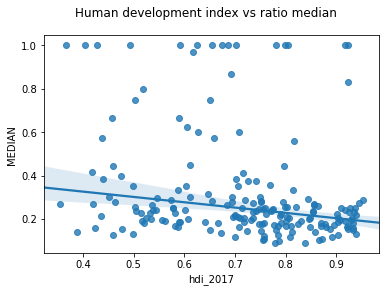

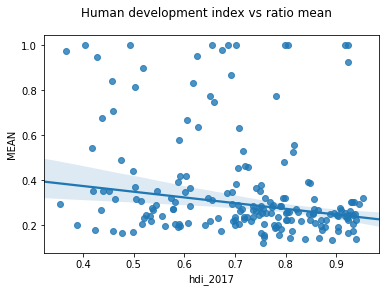

In [17]:
plt.suptitle("Human development index vs ratio median")
sns.regplot("hdi_2017", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("Human development index vs ratio mean")
sns.regplot("hdi_2017", "MEAN", data=joined, robust=True)

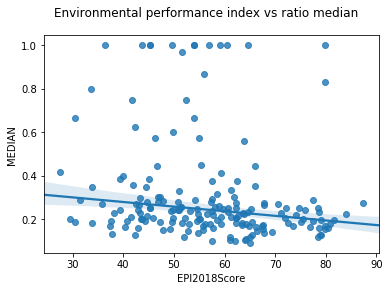

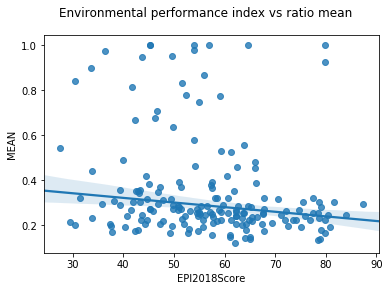

In [18]:
plt.suptitle("Environmental performance index vs ratio median")
sns.regplot("EPI2018Score", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("Environmental performance index vs ratio mean")
sns.regplot("EPI2018Score", "MEAN", data=joined, robust=True)

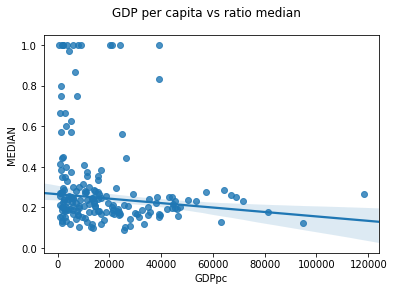

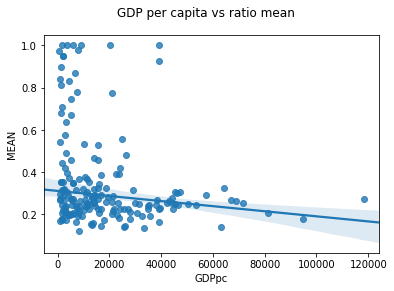

In [19]:
plt.suptitle("GDP per capita vs ratio median")
sns.regplot("GDPpc", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("GDP per capita vs ratio mean")
sns.regplot("GDPpc", "MEAN", data=joined, robust=True)